# Bitcoin 

## Stock price Prediction using LSTM (Long short-term memory) & CNN

### Author: Leo Suzuki 2024
## Introduction
This work is based on the following article: https://www.kaggle.com/meetnagadia

Data Source: https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD
Data source date range: 1.1.2019-31.12.2023

## Importing necessary libraries

In [66]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Evaluation libraries for model
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, explained_variance_score, mean_poisson_deviance, mean_gamma_deviance)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Model building libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
# Importing necessary libraries for CNN
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization



# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle


### Download newest/wanted data range from Yahoo Finance
Data Source: https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD

### Download google search trends data
Data Source: https://trends.google.com/trends/explore?date=2023-01-01%202023-12-31&q=bitcoin&hl=en-US

In [67]:
# Read the data
main_df = pd.read_csv('data/BTC-USD_Jan2019_Dec2023.csv')

In [68]:
# Check for missing values
if main_df.isnull().sum().sum() == 0:
    print('No missing values')
else:
    print('There are missing values')
    print('Number of missing values:', main_df.isnull().sum().sum())
# If data has missing values, we can drop all the missing values
# main_df = main_df.dropna()

No missing values


In [69]:
# Convert the date column to datetime
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%Y-%m-%d')

In [70]:
# Data reload
main_df = pd.read_csv('data/BTC-USD_Jan2019_Dec2023.csv')

# Loc "Date" and "Adj Close" from main df
close_df = main_df.loc[:, ['Date', 'Adj Close']]

# Convert date to datetime
close_df['Date'] = pd.to_datetime(close_df['Date'])


In [71]:
# Choose the Adj close price for the last 3 years (2021-2023)
close_df = close_df[close_df['Date'] >= '2021-01-01']
close_stock = close_df.copy()
# Print total data amount for prediction
print("Total data for prediction: ",close_df.shape[0])

Total data for prediction:  1095


In [72]:
# Considered period to predict Bitcoin close price
fig = px.line(close_df, x=close_df['Date'], y=close_df['Adj Close'], template='plotly_dark')

# Line options
fig.update_traces(line=dict(color='orange', width=2))

# Update title
fig.update_layout(title='Considered period to predict Bitcoin close price', xaxis_title='Date', yaxis_title='Stock Price')

# Show the figure
fig.show()

/Users/LeMac/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### Normalizing Data
Normalization data preparation for machine learning. The goal is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.
MinMaxScaler. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.

In [73]:
# Deleting date column and normalizing using MinMax Scaler

# Delete the "Date" column from the DataFrame
del close_df['Date']

# Initialize MinMaxScaler with a feature range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the "Adj Close" column to a 2D array (required by MinMaxScaler) and normalize the data
close_df = scaler.fit_transform(np.array(close_df).reshape(-1, 1))

## Splitting the Data into Training and Testing Sets

In [74]:
# Split the data into training and testing sets (80% training and 20% testing)
# Shuffle false because need to be chronological order
train_data, test_data = train_test_split(close_df, test_size=0.2, shuffle=False)

# Check print for datasets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (876, 1)
Test data shape: (219, 1)


### Function to create a dataset for time-series forecasting.

In [75]:
def create_dataset(dataset, time_step=1):
    """
    Function to create a dataset for time-series forecasting.

    Args:
    - dataset: Input time-series data as a 2D numpy array, where each row represents a time step and each column represents a feature.
    - time_step: Number of time steps to look back in the past for creating input sequences.

    Returns:
    - data_x: Input sequences, where each sequence is a 2D numpy array of shape (time_step, num_features).
    - data_y: Target values corresponding to each input sequence.
    """
    data_x = []  # Initialize lists to store input sequences and corresponding target values
    data_y = []
    
    for i in range(len(dataset) - time_step - 1):
        # Extract input sequence from the dataset
        a = dataset[i:(i + time_step), 0]  # Select 'time_step' consecutive rows starting from index 'i' for the first feature (column 0)
        data_x.append(a)  # Append the input sequence to the list 'data_x'

        # Extract target value corresponding to the next time step
        data_y.append(dataset[i + time_step, 0])  # Append the target value to the list 'data_y'

    return np.array(data_x), np.array(data_y)  # Convert lists to numpy arrays and return them

### Transform the Adj Close price based on Time-series-analysis forecasting requirement example value 15

In [76]:
#  This parameter specifies the number of time steps to look back in the past for create_dataset()
time_step = 15

# Create the dataset with time step
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Print the shape of the training and testing sets
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (860, 15)
y_train shape:  (860,)
X_test shape:  (203, 15)
y_test shape:  (203,)


In [77]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Print the shape of the reshaped training and testing sets
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (860, 15, 1)
X_test shape:  (203, 15, 1)


# LSTM model training

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) that can learn and predict time series data. It is well-suited for making predictions based on time series data, such as stock prices. In this section, we will build an LSTM model to predict the future stock price of Bitcoin. Using Keras library to build the LSTM model.

In [78]:
# LSTM model training
lstm_model = Sequential()
# Add the LSTM layer to the model
lstm_model.add(LSTM(100, input_shape=(None, 1), activation='relu', return_sequences=True))
# Add the LSTM layer to the model
lstm_model.add(LSTM(50, activation='relu'))
# Add a dense (fully connected) layer to the model
lstm_model.add(Dense(1))
# Initialize the Adam optimizer with learning rate
optimizer = Adam(learning_rate=0.001)
# Compile the model with the optimizer
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
# Train the model using the training sets
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)


Epoch 1/200
27/27 [==============================] - 4s 32ms/step - loss: 0.0555 - val_loss: 0.0027
Epoch 2/200
27/27 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 3/200
27/27 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 8.6673e-04
Epoch 4/200
27/27 [==============================] - 1s 34ms/step - loss: 0.0036 - val_loss: 8.0513e-04
Epoch 5/200
27/27 [==============================] - 1s 23ms/step - loss: 0.0031 - val_loss: 7.6813e-04
Epoch 6/200
27/27 [==============================] - 1s 21ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 7/200
27/27 [==============================] - 1s 22ms/step - loss: 0.0026 - val_loss: 7.0602e-04
Epoch 8/200
27/27 [==============================] - 1s 24ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 9/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 5.8521e-04
Epoch 10/200
27/27 [==============================] - 1s 20ms/step - loss: 0.002

## Plotting Loss vs Validation Loss

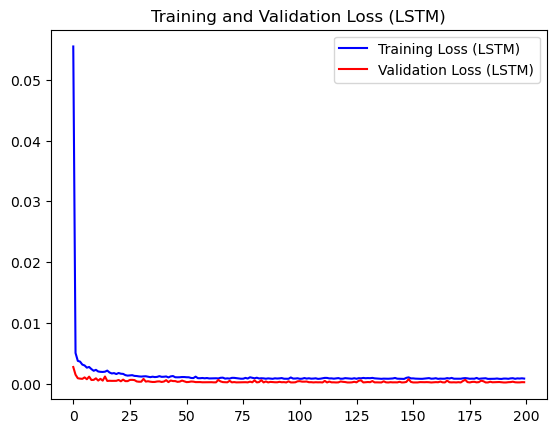

<Figure size 640x480 with 0 Axes>

In [97]:
# Evaluate the LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting Loss vs Validation Loss for LSTM
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss (LSTM)')
plt.plot(epochs, val_loss, 'r', label='Validation Loss (LSTM)')
plt.title('Training and Validation Loss (LSTM)')
plt.legend(loc='upper right')
plt.figure()
plt.show()

### Try prediction and check performance metrics

In [98]:
# Print the model summary to check the expected input shape
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 100)         40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [99]:
# Make predictions using the trained LSTM model
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 [==============================] - 0s 7ms/step


((860, 1), (203, 1))

In [100]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_y_train = scaler.inverse_transform(y_train.reshape(-1,1))
original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

### Calculate RMSE, MSE and MAE performance metrics LSTM

In [101]:
# Calculate RMSE performance metrics LSTM
rmse_train_lstm = np.sqrt(mean_squared_error(original_y_train, train_predict))
mse_train_lstm = mean_squared_error(original_y_train, train_predict)
mae_train_lstm = mean_absolute_error(original_y_train, train_predict)

# Calculate RMSE performance metrics
rmse_test_lstm = np.sqrt(mean_squared_error(original_y_test, test_predict))
mse_test_lstm = mean_squared_error(original_y_test, test_predict)
mae_test_lstm = mean_absolute_error(original_y_test, test_predict)

# Will be printed in the end with CNN metrics

## Variance regression score LSTM

In [102]:
# Explained variance regression score
explained_variance_score_train = explained_variance_score(original_y_train, train_predict)
explained_variance_score_test = explained_variance_score(original_y_test, test_predict)

# Print the explained variance regression score
print("Train Data Explained Variance Regression Score LSTM:", explained_variance_score_train)
print("Test Data Explained Variance Regression Score LSTM:", explained_variance_score_test)

Train Data Explained Variance Regression Score LSTM: 0.9894807296707551
Test Data Explained Variance Regression Score LSTM: 0.9858989641458993


## R squared score for regression LSTM

In [103]:
# R-squared score for regression
r2_score_train = r2_score(original_y_train, train_predict)
r2_score_test = r2_score(original_y_test, test_predict)

# Print the R-squared score for regression
print("Train Data R-squared Score for Regression LSTM:", r2_score_train)
print("Test Data R-squared Score for Regression LSTM:", r2_score_test)

Train Data R-squared Score for Regression LSTM: 0.9890261979961803
Test Data R-squared Score for Regression LSTM: 0.9822138066832838


## Regression Loss Mean Gamma Deviance regression loss (MGD) and Mean Poisson Deviance regression loss (MPD) LSTM

In [104]:
MGD_train = mean_gamma_deviance(original_y_train, train_predict)
MPD_train = mean_poisson_deviance(original_y_train, train_predict)
MGD_test = mean_gamma_deviance(original_y_test, test_predict)
MPD_test = mean_poisson_deviance(original_y_test, test_predict)

# Print the regression loss
print("Train Data Mean Gamma Deviance Regression Loss:", MGD_train)
print("Train Data Mean Poisson Deviance Regression Loss:", MPD_train)
# Print line
print("\n------------------------------------\n")
print("Test Data Mean Gamma Deviance Regression Loss:", MGD_test)
print("Test Data Mean Poisson Deviance Regression Loss:", MPD_test)


Train Data Mean Gamma Deviance Regression Loss: 0.0014204288399548627
Train Data Mean Poisson Deviance Regression Loss: 51.13063513104428

------------------------------------

Test Data Mean Gamma Deviance Regression Loss: 0.0005538665108893658
Test Data Mean Poisson Deviance Regression Loss: 17.548611406843552


## Comparison of original stock close price and predicted stock close price

In [105]:
# Create an empty array with the same shape as the original close_df (presumably the DataFrame containing stock prices)
trainPredictPlot = np.empty_like(close_df)
testPredictPlot = np.empty_like(close_df)

# Fill the entire trainPredictPlot and testPredictPlot arrays with NaN (Not a Number)
trainPredictPlot[:, :] = np.nan
testPredictPlot[:, :] = np.nan

# Update the trainPredictPlot array with the predicted values from the model
# The train_predict array contains the predictions made by the model for the training data
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Update the testPredictPlot array with the predicted values from the model
# The test_predict array contains the predictions made by the model for the test data
testPredictPlot[len(train_predict)+(time_step*2)+1:len(close_df)-1, :] = test_predict

# Print the shape of the trainPredictPlot array
print("Train Predict data: ", trainPredictPlot.shape)
names = cycle(['Original Close Price','Train Predicted Close Price','Test Predicted Close Price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Adj Close'],
                       'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                       'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf    , x=plotdf['date']
                        , y=[plotdf['original_close']
                        , plotdf['train_predicted_close']
                        , plotdf['test_predicted_close']]
                        , labels={'value':'Stock price','date': 'Date', 'variable': 'Close Price'}, title='Comparison of original stock close price vs predicted stock close price (LSTM)', template='plotly_dark')


# Show scrollbar
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))


# Update names for each line
fig.for_each_trace(lambda t:  t.update(name = next(names)))

# Show the figure
fig.show()

Train Predict data:  (1095, 1)


/Users/LeMac/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Predicting the future stock price of Bitcoin 30 days ahead

In [106]:
def predict_next_days_lstm(model, test_data, time_step, pred_days):
    temp_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    n_steps = time_step

    i = 0
    while i < pred_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, n_steps, 1)
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape(1, n_steps, 1)
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1

    return lst_output

In [107]:
# Predict the stock price for the next 30 days using the LSTM model
pred_days = 30
predicted_prices = predict_next_days_lstm(lstm_model, test_data, time_step, pred_days)
print("Predicted prices for the next", pred_days, "days (LSTM):", predicted_prices)

Predicted prices for the next 30 days (LSTM): [[0.5052089095115662], [0.49960967898368835], [0.49406400322914124], [0.4883446991443634], [0.4823820888996124], [0.4763433337211609], [0.47007662057876587], [0.4637911021709442], [0.4576108157634735], [0.45147350430488586], [0.44531136751174927], [0.43916165828704834], [0.43305695056915283], [0.42699745297431946], [0.42099323868751526], [0.4150431454181671], [0.4091472625732422], [0.40330755710601807], [0.3975263833999634], [0.39180368185043335], [0.3861551582813263], [0.38057419657707214], [0.37505337595939636], [0.3695923984050751], [0.3641897439956665], [0.35884034633636475], [0.35354048013687134], [0.3482895493507385], [0.3430842459201813], [0.33792081475257874]]


In [108]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [109]:
# Plot the predicted stock price for the next 30 days
fig = go.Figure()

fig.add_trace(go.Scatter(x=last_days, y=scaler.inverse_transform(test_data[len(test_data)-time_step:]).reshape(1,-1)[0], mode='lines', name='Last 15 days', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=day_pred, y=scaler.inverse_transform(predicted_prices).reshape(1,-1)[0], mode='lines', name='Next 30 days', line=dict(color='red')))

# Update the layout, title, legend, x-axis and y-axis
fig.update_layout(title='Predicted Stock Price for the Next 30 Days', xaxis_title='Days', yaxis_title='Stock Price', template='plotly_dark')

# Show the figure
fig.show()

## Plotting entire closing Stock price with next 30 days prediction LSTM

In [110]:
# Plot the entire closing Stock price with next 30 days prediction
lstmdf = close_df.tolist()
lstmdf.extend(predicted_prices)

# Inverse transform the scaled data
lstmdf = scaler.inverse_transform(lstmdf)

# Reshape the data to a 1D array
lstmdf = np.array(lstmdf).reshape(-1)

# Create the plot using Plotly
fig = px.line(lstmdf, labels={'value': 'Stock price', 'index': 'Timestamp'}, title='Plotting whole closing stock price with prediction', template='plotly_dark')
fig.update_layout(title_text='Plotting whole closing stock price with prediction', template='plotly_dark')
fig.update_traces(name='Close Price')

# Show the figure
fig.show()


## CNN model training

In [111]:
# CNN model training
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))  # Add dropout layer
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))  # Add dropout layer
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))  # Increase the number of neurons in the dense layer
cnn_model.add(Dense(1))

# Compile the CNN model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the CNN model with a reduced learning rate and more epochs
history_cnn = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32, verbose=1)


Epoch 1/300
27/27 [==============================] - 1s 10ms/step - loss: 0.1246 - val_loss: 0.0468
Epoch 2/300
27/27 [==============================] - 0s 4ms/step - loss: 0.0593 - val_loss: 0.0190
Epoch 3/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0230 - val_loss: 0.0044
Epoch 4/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0024
Epoch 5/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.0030
Epoch 6/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 7/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 8/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0035
Epoch 9/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 10/300
27/27 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 11

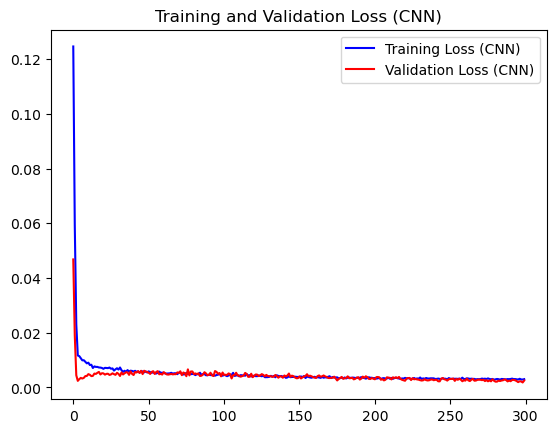

In [112]:
# Evaluate the CNN model
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
# Plotting Loss vs Validation Loss for CNN
epochs_cnn = range(len(loss))

plt.plot(epochs_cnn, loss, 'b', label='Training Loss (CNN)')
plt.plot(epochs_cnn, val_loss, 'r', label='Validation Loss (CNN)')
plt.title('Training and Validation Loss (CNN)')
plt.legend(loc='upper right')
plt.show()

In [113]:
# Print model
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 13, 64)            256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 6, 64)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 4, 32)             6176      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 2, 32)             0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 2, 32)            

### Try prediction and check performance metrics

In [49]:
# Invert the scaling of the predicted values
train_predict_cnn = scaler.inverse_transform(train_predict_cnn)
test_predict_cnn = scaler.inverse_transform(test_predict_cnn)
original_y_train_cnn = scaler.inverse_transform(y_train.reshape(-1, 1))
original_y_test_cnn = scaler.inverse_transform(y_test.reshape(-1, 1))

### Calculate RMSE, MSE and MAE performance metrics CNN

In [50]:
# Calculate RMSE performance metrics CNN
rmse_train_cnn = np.sqrt(mean_squared_error(original_y_train_cnn, train_predict_cnn))
mse_train_cnn = mean_squared_error(original_y_train_cnn, train_predict_cnn)
mae_train_cnn = mean_absolute_error(original_y_train_cnn, train_predict_cnn)

# Calculate RMSE performance metrics CNN
rmse_test_cnn = np.sqrt(mean_squared_error(original_y_test_cnn, test_predict_cnn))
mse_test_cnn = mean_squared_error(original_y_test_cnn, test_predict_cnn)
mae_test_cnn = mean_absolute_error(original_y_test_cnn, test_predict_cnn)

# Will be printed in the end with LSTM metrics

Train Data Performance Metrics CNN:
RMSE:  4546.200389212118
MSE:  20667937.978872415
MAE:  3205.3017238033417

------------------------------------

Test Data Performance Metrics CNN:
RMSE:  2213.0118657121675
MSE:  4897421.517782849
MAE:  1755.0693023589897


## Variance regression score CNN

In [51]:
# Explained variance regression score
explained_variance_score_train_cnn = explained_variance_score(original_y_train_cnn, train_predict_cnn)
explained_variance_score_test_cnn = explained_variance_score(original_y_test_cnn, test_predict_cnn)

# Print the explained variance regression score
print("Train Data Explained Variance Regression Score CNN:", explained_variance_score_train_cnn)
print("Test Data Explained Variance Regression Score CNN:", explained_variance_score_test_cnn)

Train Data Explained Variance Regression Score CNN: 0.9282229804448897
Test Data Explained Variance Regression Score CNN: 0.9376910932000001


## R squared score for regression CNN

In [52]:
# R-squared score for regression
r2_score_train_cnn = r2_score(original_y_train_cnn, train_predict_cnn)
r2_score_test_cnn = r2_score(original_y_test_cnn, test_predict_cnn)

# Print the R-squared score for regression
print("Train Data R-squared Score for Regression CNN:", r2_score_train_cnn)
print("Test Data R-squared Score for Regression CNN:", r2_score_test_cnn)

Train Data R-squared Score for Regression CNN: 0.890387684606478
Test Data R-squared Score for Regression CNN: 0.8481961160671729


In [114]:
# Make predictions using the trained CNN model
train_predict_cnn = cnn_model.predict(X_train)
test_predict_cnn = cnn_model.predict(X_test)
train_predict_cnn.shape, test_predict_cnn.shape

7/7 [==============================] - 0s 3ms/step


((860, 1), (203, 1))

In [115]:
# Shift test predictions for plotting
testPredictPlot_cnn = np.empty_like(close_df)
testPredictPlot_cnn[:, :] = np.nan
testPredictPlot_cnn[len(train_data) + time_step:len(train_data) + len(test_predict_cnn) + time_step, :] = test_predict_cnn

### Regression Loss Mean Gamma Deviance regression loss (MGD) and Mean Poisson Deviance regression loss (MPD) CNN

In [116]:
MGD_train_cnn = mean_gamma_deviance(original_y_train_cnn, train_predict_cnn)
MPD_train_cnn = mean_poisson_deviance(original_y_train_cnn, train_predict_cnn)
MGD_test_cnn = mean_gamma_deviance(original_y_test_cnn, test_predict_cnn)
MPD_test_cnn = mean_poisson_deviance(original_y_test_cnn, test_predict_cnn)

# Print the regression loss
print("Train Data Mean Gamma Deviance Regression Loss CNN:", MGD_train_cnn)
print("Train Data Mean Poisson Deviance Regression Loss CNN:", MPD_train_cnn)
# Print line
print("\n------------------------------------\n")
print("Test Data Mean Gamma Deviance Regression Loss CNN:", MGD_test_cnn)
print("Test Data Mean Poisson Deviance Regression Loss CNN:", MPD_test_cnn)

Train Data Mean Gamma Deviance Regression Loss CNN: 308136.1498029861
Train Data Mean Poisson Deviance Regression Loss CNN: 760503.2773325851

------------------------------------

Test Data Mean Gamma Deviance Regression Loss CNN: 246249.7373362591
Test Data Mean Poisson Deviance Regression Loss CNN: 679034.111011882


### Comparison of original stock close price and predicted stock close price CNN

In [117]:
# Shift train predictions for plotting
trainPredictPlot_cnn = np.empty_like(close_df)
trainPredictPlot_cnn[:, :] = np.nan
trainPredictPlot_cnn[time_step:len(train_predict_cnn) + time_step, :] = train_predict_cnn

# Print the shape of the trainPredictPlot array
print("Train Predict data: ", trainPredictPlot_cnn.shape)

Train Predict data:  (1095, 1)


In [118]:
# Plotting only CNN predictions

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Adj Close'],
                       'train_predicted_close': trainPredictPlot_cnn.reshape(1,-1)[0].tolist(),
                       'test_predicted_close': testPredictPlot_cnn.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf    , x=plotdf['date']
                        , y=[plotdf['original_close']
                        , plotdf['train_predicted_close']
                        , plotdf['test_predicted_close']]
                        , labels={'value':'Stock price','date': 'Date', 'variable': 'Close Price'}, title='Comparison of original stock close price vs predicted stock close price', template='plotly_dark')

fig.update_layout(title='Comparison of original stock close price vs predicted stock close price', template='plotly_dark')

# Show scrollbar
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

# Update names for each line
fig.for_each_trace(lambda t:  t.update(name = next(names)))

/Users/LeMac/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [119]:
def predict_next_days_cnn(model, test_data, time_step, pred_days):
    temp_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    n_steps = time_step

    i = 0
    while i < pred_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, n_steps, 1)
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape(1, n_steps, 1)
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1

    return lst_output


In [120]:
# Predict the stock price for the next 30 days using the CNN model
pred_days = 30
predicted_pricesCNN = predict_next_days_cnn(cnn_model, test_data, time_step, pred_days)
print("Predicted prices for the next", pred_days, "days:", predicted_prices)

Predicted prices for the next 30 days: [[0.5052089095115662], [0.49960967898368835], [0.49406400322914124], [0.4883446991443634], [0.4823820888996124], [0.4763433337211609], [0.47007662057876587], [0.4637911021709442], [0.4576108157634735], [0.45147350430488586], [0.44531136751174927], [0.43916165828704834], [0.43305695056915283], [0.42699745297431946], [0.42099323868751526], [0.4150431454181671], [0.4091472625732422], [0.40330755710601807], [0.3975263833999634], [0.39180368185043335], [0.3861551582813263], [0.38057419657707214], [0.37505337595939636], [0.3695923984050751], [0.3641897439956665], [0.35884034633636475], [0.35354048013687134], [0.3482895493507385], [0.3430842459201813], [0.33792081475257874]]


In [121]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [122]:
# Plot the predicted stock price for the next 30 days using CNN
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=last_days, y=scaler.inverse_transform(test_data[len(test_data) - time_step:]).reshape(1, -1)[0],
               mode='lines', name='Last 15 days', line=dict(color='blue')))
fig.add_trace(
    go.Scatter(x=day_pred, y=scaler.inverse_transform(predicted_pricesCNN).reshape(1, -1)[0], mode='lines',
               name='Next 30 days (CNN)', line=dict(color='red')))

# Update the layout, title, legend, x-axis and y-axis
fig.update_layout(title='CNN Predicted Stock Price for the Next 30 Days', xaxis_title='Days', yaxis_title='Stock Price',
                  template='plotly_dark')

# Show the figure
fig.show()

## Plotting entire closing Stock price with next 30 days prediction CNN

In [123]:
# Plot the entire closing Stock price with next 30 days prediction
cnndf = close_df.tolist()
cnndf.extend((np.array(predicted_pricesCNN)).reshape(-1, 1).tolist())
cnndf = scaler.inverse_transform(cnndf).reshape(1, -1).tolist()[0]

fig = px.line(cnndf, labels={'value': 'Stock price', 'index': 'Timestamp', 'variable': 'Stock Price'},
              title='Plotting whole closing stock price with prediction', template='plotly_dark')
fig.update_layout(title_text='Plotting whole closing stock price with prediction (CNN)', template='plotly_dark')
fig.update_traces(name='Close Price')

# Show the figure
fig.show()

In [124]:
# Plot the predicted stock price for the next 30 days LSTM and CNN
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=last_days, y=scaler.inverse_transform(test_data[len(test_data) - time_step:]).reshape(1, -1)[0],
               mode='lines', name='Last 15 days', line=dict(color='blue')))
fig.add_trace(
    go.Scatter(x=day_pred, y=scaler.inverse_transform(predicted_prices).reshape(1, -1)[0], mode='lines',
               name='Next 30 days (LSTM)', line=dict(color='green')))
fig.add_trace(
    go.Scatter(x=day_pred, y=scaler.inverse_transform(predicted_pricesCNN).reshape(1, -1)[0], mode='lines',
               name='Next 30 days (CNN)', line=dict(color='red')))

# Update the layout, title, legend, x-axis and y-axis
fig.update_layout(title='Predicted Stock Price for the Next 30 Days',
                  xaxis_title='Days', yaxis_title='Stock Price', template='plotly_dark')

# Show the figure
fig.show()

## BOTH LSTM and CNN model performance metrics

In [125]:
# Calculate performance metrics for CNN model
# Invert the scaling of the original y values for comparison
original_y_train_cnn = scaler.inverse_transform(y_train.reshape(-1, 1))
original_y_test_cnn = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MSE, and MAE for CNN model
rmse_train_cnn = np.sqrt(mean_squared_error(original_y_train_cnn, train_predict_cnn))
mse_train_cnn = mean_squared_error(original_y_train_cnn, train_predict_cnn)
mae_train_cnn = mean_absolute_error(original_y_train_cnn, train_predict_cnn)

rmse_test_cnn = np.sqrt(mean_squared_error(original_y_test_cnn, test_predict_cnn))
mse_test_cnn = mean_squared_error(original_y_test_cnn, test_predict_cnn)
mae_test_cnn = mean_absolute_error(original_y_test_cnn, test_predict_cnn)

# Print result for both tests

In [126]:
# Print performance metrics for LSTM and CNN models
print("LSTM Model Performance Metrics:")
print("Train Data RMSE: ", rmse_train_lstm)
print("Train Data MSE: ", mse_train_lstm)
print("Train Data MAE: ", mae_train_lstm)
print("Test Data RMSE: ", rmse_test_lstm)
print("Test Data MSE: ", mse_test_lstm)
print("Test Data MAE: ", mae_test_lstm)

print("\nCNN Model Performance Metrics:")
print("Train Data RMSE: ", rmse_train_cnn)
print("Train Data MSE: ", mse_train_cnn)
print("Train Data MAE: ", mae_train_cnn)
print("Test Data RMSE: ", rmse_test_cnn)
print("Test Data MSE: ", mse_test_cnn)
print("Test Data MAE: ", mae_test_cnn)

LSTM Model Performance Metrics:
Train Data RMSE:  1438.4589046689903
Train Data MSE:  2069164.020421511
Train Data MAE:  988.3337039186772
Test Data RMSE:  757.5020370784214
Test Data MSE:  573809.3361779581
Test Data MAE:  544.4290525418718

CNN Model Performance Metrics:
Train Data RMSE:  38226.361128033626
Train Data MSE:  1461254685.09084
Train Data MAE:  35674.995435588906
Test Data RMSE:  32266.410788542267
Test Data MSE:  1041121265.1749569
Test Data MAE:  31762.567974498448


# END OF PREDICTION CODE